# Домашнее задание №4. Семантическая сегментация.

In [28]:
%tensorflow_version 2.x

In [29]:
#загрузка необходимых библиотек и модулей
import os
import skimage.io as io
import numpy as np

import tensorflow as tf
import imageio
import matplotlib.pyplot as plt

## Задание
Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO. 
Библиотеки: [Python, Tensorflow].

## План решения
[0. Загрузка данных и установка cocoapi](#section_0)

[1. Создание датасетов](#section_1)

[2. Построение и обучение модели U-net](#section_2)

[3. Оценка качества модели](#section_3)

### 0. Загрузка данных и установка cocoapi <a id='section_0'></a>

Загрузка датасета COCO и COCO API

In [30]:
!rm -r data 

In [31]:
!mkdir -p data

#скачиваем датасеты
!cd data && wget http://images.cocodataset.org/zips/train2017.zip 
!cd data && wget http://images.cocodataset.org/zips/val2017.zip 
!cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

#распаковываем датасеты
!cd data && unzip -q train2017.zip
!cd data && unzip -q val2017.zip
!cd data && unzip -q annotations_trainval2017.zip

#скачиваем и устанавливаем cocoapi
!cd data && git clone https://github.com/cocodataset/cocoapi
!cd data/cocoapi/PythonAPI && make

--2022-08-01 12:57:53--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.129.73
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.129.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  33.6MB/s    in 9m 16s  

2022-08-01 13:07:10 (33.2 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2022-08-01 13:07:10--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.226.153
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.226.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  33.6MB/s    in 24s     

2022-08-01 13:07:34 (32.5 MB/s) - 

In [32]:
#удаляем архивы (чтобы освободить место на диске)
!cd data && rm train2017.zip
!cd data && rm val2017.zip
!cd data && rm annotations_trainval2017.zip

Подготовка COCO API

In [33]:
COCO_ROOT = './data/'

import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### 1. Создание датасетов <a id='section_01'></a>

Универсальный класс Dataset для сегментации

In [34]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
       # dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

Класс для сегментационного датасета COCO (класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных)

In [35]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [36]:
#создаем представителей класса
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=20.31s)
creating index...
index created!
loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


In [37]:
#создаем датасеты
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 2

train_ds = COCO_dataset_train.train_dataset(BATCH_SIZE, EPOCHS, IMG_HEIGHT)
val_ds = COCO_dataset_val.val_dataset(BATCH_SIZE, IMG_HEIGHT)

### 2. Построение и обучение модели U-Net <a id='section_2'></a>

Создание модели U-Net

In [38]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

Визуализация U-Net

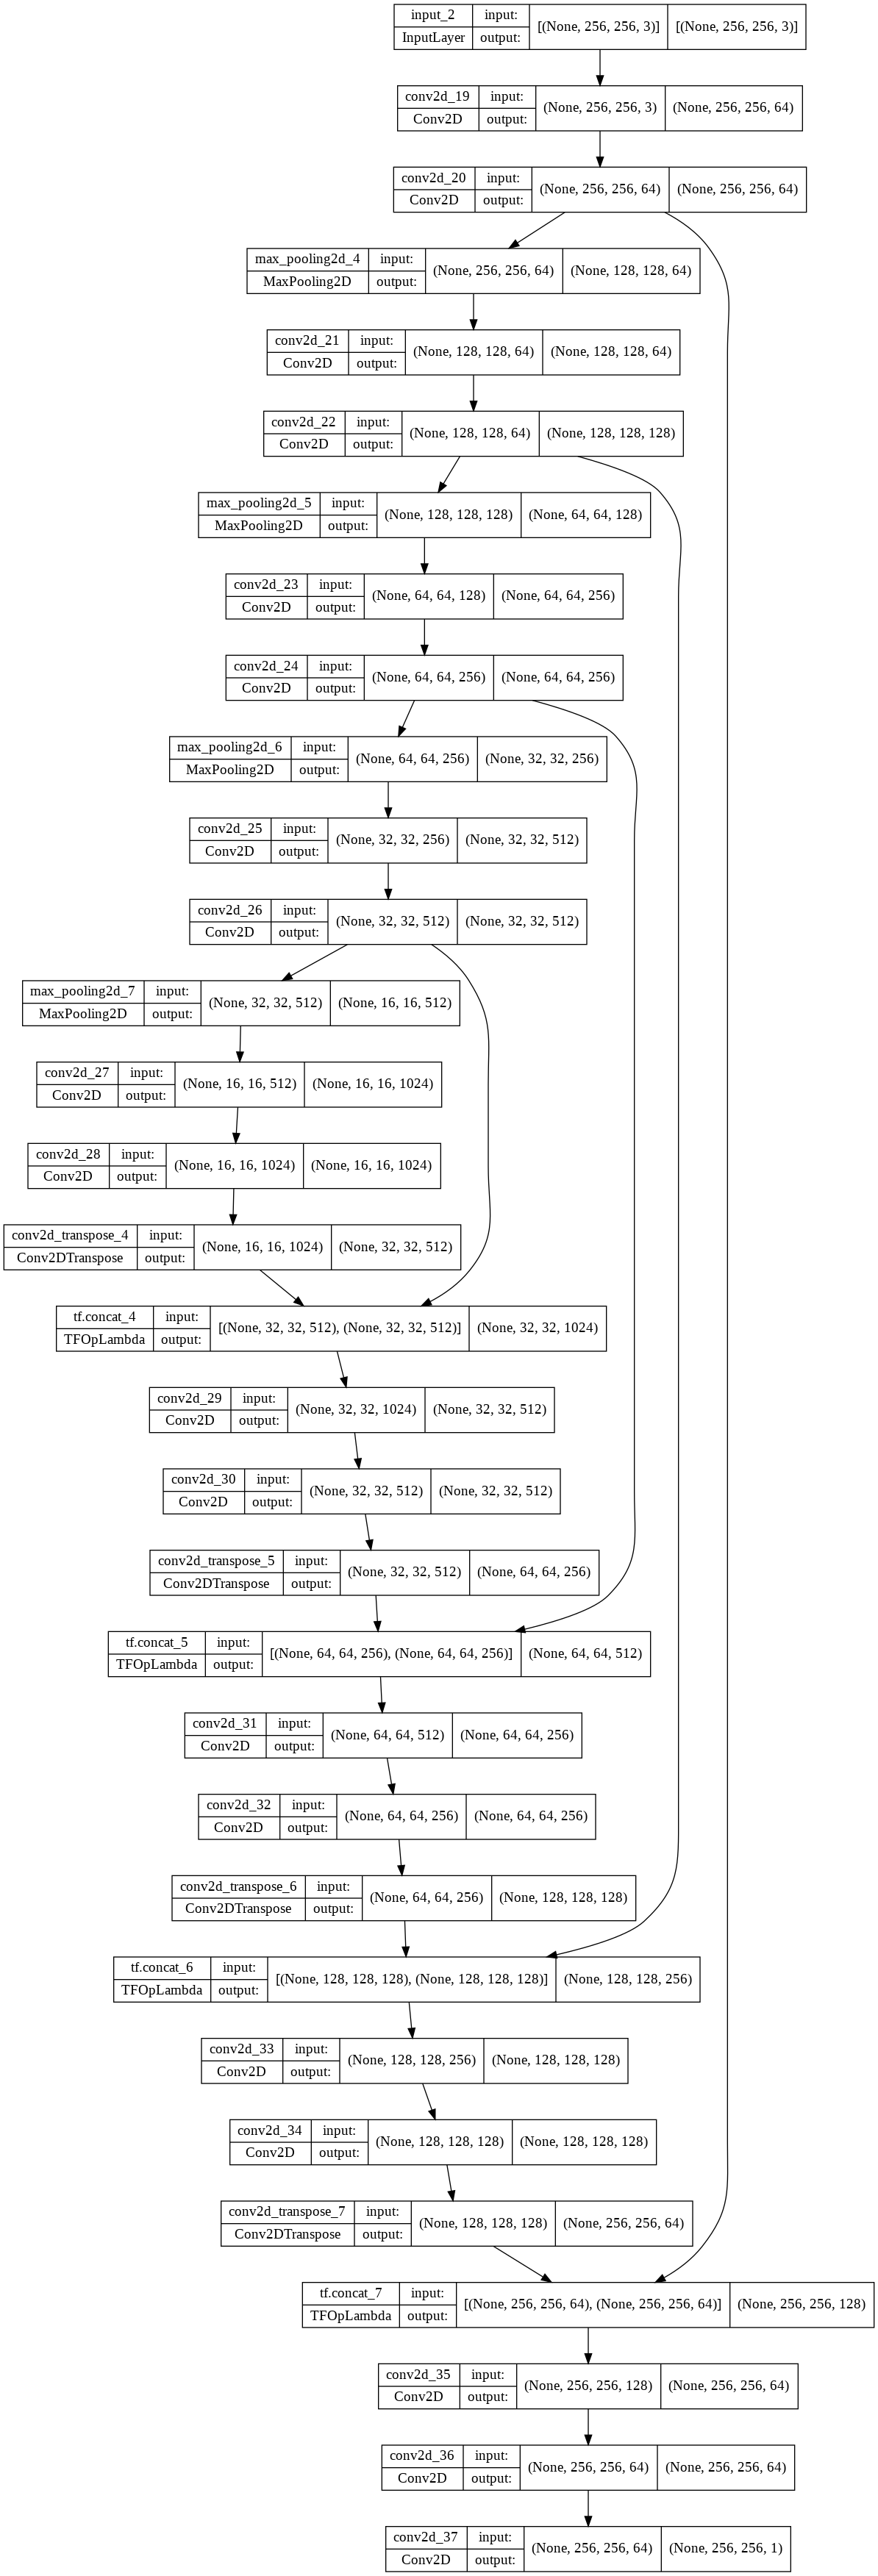

In [39]:
tf.keras.utils.plot_model(model, show_shapes=True)

Обучение модели

In [40]:
%%time

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

hist = model.fit(train_ds, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data = val_ds)

Epoch 1/2
4007/4007 [==============================] - 4190s 1s/step - loss: 0.4652 - accuracy: 0.7851 - val_loss: 0.4591 - val_accuracy: 0.7799
Epoch 2/2
4007/4007 [==============================] - 4089s 1s/step - loss: 0.4034 - accuracy: 0.8105 - val_loss: 0.4522 - val_accuracy: 0.7861
CPU times: user 1h 46min 46s, sys: 3min 50s, total: 1h 50min 36s
Wall time: 2h 18min 45s


### 3. Оценка качества модели <a id='section_3'></a>

Оценка качества модели

In [43]:
model.evaluate(val_ds)

168/168 [==============================] - 84s 499ms/step - loss: 0.4522 - accuracy: 0.7861


[0.4521562159061432, 0.7860739827156067]

Визуализация предсказаний модели

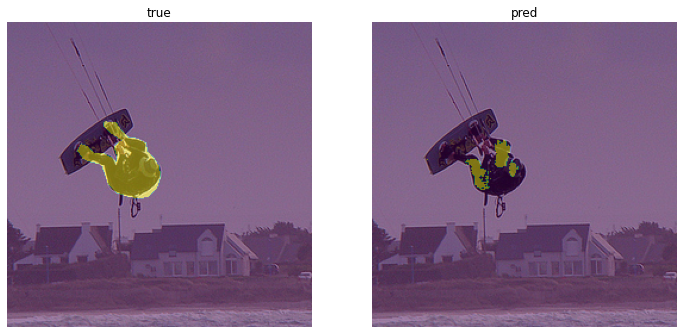

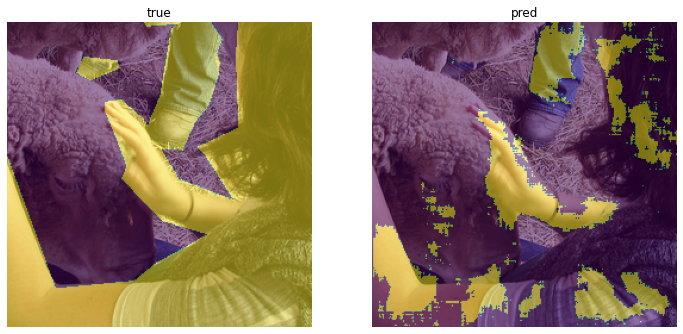

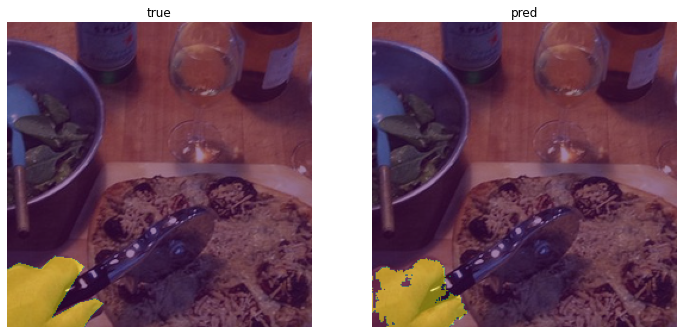

In [44]:
train_x, train_y = next(iter(val_ds))

pred_prob = model(train_x[:4]).numpy()
pred_mask = (pred_prob[..., 0] > 0.5).astype(np.float32)

for i in range(3):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('true')
    plt.imshow(train_x[i])
    plt.imshow(train_y[i, ..., 0], alpha=0.5)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('pred')
    plt.imshow(train_x[i])
    plt.imshow(pred_mask[i], alpha=0.5)
    plt.axis('off')

**Вывод:** имеющиеся вычислительные мощности позволили обучить модель только на двух эпохах (при увеличении числа эпох colab вылетает). В следствие чего качество предсказаний модели оставляет желать лучшего.